In [2]:
from keras import applications

net = applications.VGG16(include_top=False,
                           weights='imagenet')

layers = {layer.name: layer for layer in net.layers}

In [8]:
for l in layers.keys():
    print(l)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [27]:
from keras import backend as K

layer_name = 'block5_conv3'
filter_index = 0  # can be any integer from 0 to 511, as there are 512 filters in that layer

def get_filter_image(input_img, layer_name='block5_conv3', filter_index=0, steps=20):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    
    layer_output = layers[layer_name].output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # compute the gradient of the input picture wrt this loss
    print('input: ', input_img)
    grads = K.gradients(loss, input_img)[0]
    print('grads: ', grads)
    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
    return input_img_data

In [28]:
import numpy as np

img_width = 32
img_height = 32
# we start from a gray image with some noise
input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.
# run gradient ascent for 20 steps

out = get_filter_image(input_img_data)


input:  [[[[ 142.82235611  138.30002627  129.54711496 ...,  129.24690205
     130.72961341  135.26653351]
   [ 128.73865907  131.62698075  133.46459338 ...,  136.22646682
     128.63091923  145.95787656]
   [ 131.67659467  135.85968053  128.44507054 ...,  141.99311899
     135.27215027  147.7512896 ]
   ..., 
   [ 147.01319912  133.5162241   132.50080344 ...,  146.60978277
     129.12053719  132.50931813]
   [ 137.27664088  131.1715694   141.62232494 ...,  133.78512546
     141.39558207  146.74820195]
   [ 133.13482967  138.12180831  142.12678074 ...,  129.34096857
     136.89703217  142.47522639]]

  [[ 142.78651052  146.015027    136.76590695 ...,  128.61258032
     141.20731354  145.83978812]
   [ 132.40461712  145.16187977  129.59926276 ...,  143.67551     147.48065495
     134.21674086]
   [ 139.94032028  142.39164715  143.54321647 ...,  138.39600404
     146.05890609  130.88271776]
   ..., 
   [ 128.99856548  139.20858384  136.77563325 ...,  135.25300881
     145.11994445  131.65

ValueError: Tried to convert 'x' to a tensor and failed. Error: None values not supported.

In [104]:
import numpy as np
from keras.applications import vgg16
from keras import backend as K
from tqdm import tqdm

# dimensions of the generated pictures for each filter.
img_width = 32
img_height = 32

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def get_filters(model):
    # this is the placeholder for the input images
    input_img = model.input

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    kept_filters = []
    for layer_name in layer_dict.keys():
        if 'conv' not in layer_name:
            continue
        layer_filters = []
        for filter_index in tqdm(range(15)):

            # we build a loss function that maximizes the activation
            # of the nth filter of the layer considered
            layer_output = layer_dict[layer_name].output
            if K.image_data_format() == 'channels_first':
                loss = K.mean(layer_output[:, filter_index, :, :])
            else:
                loss = K.mean(layer_output[:, :, :, filter_index])

            # we compute the gradient of the input picture wrt this loss
            grads = K.gradients(loss, input_img)[0]

            # normalization trick: we normalize the gradient
            grads = normalize(grads)

            # this function returns the loss and grads given the input picture
            iterate = K.function([input_img], [loss, grads])

            # step size for gradient ascent
            step = 1.

            # we start from a gray image with some random noise
            if K.image_data_format() == 'channels_first':
                input_img_data = np.random.random((1, 3, img_width, img_height))
            else:
                input_img_data = np.random.random((1, img_width, img_height, 3))
            input_img_data = (input_img_data - 0.5) * 20 + 128

            # we run gradient ascent for 20 steps
            for i in range(20):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step
                if loss_value <= 0.:
                    # some filters get stuck to 0, we can skip them
                    break

            # decode the resulting input image
            if loss_value > 0:
                img = deprocess_image(input_img_data[0])
                kept_filters.append((img, loss_value))
        layer_filters.sort(key=lambda x: x[1], reverse=True)
        kept_filters += layer_filters[:8]

# build the VGG16 network with ImageNet weights
model = vgg16.VGG16(weights='imagenet', include_top=False)
get_filters(model)



  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:02<00:37,  2.66s/it]

 13%|█▎        | 2/15 [00:05<00:33,  2.54s/it]



KeyboardInterrupt: 

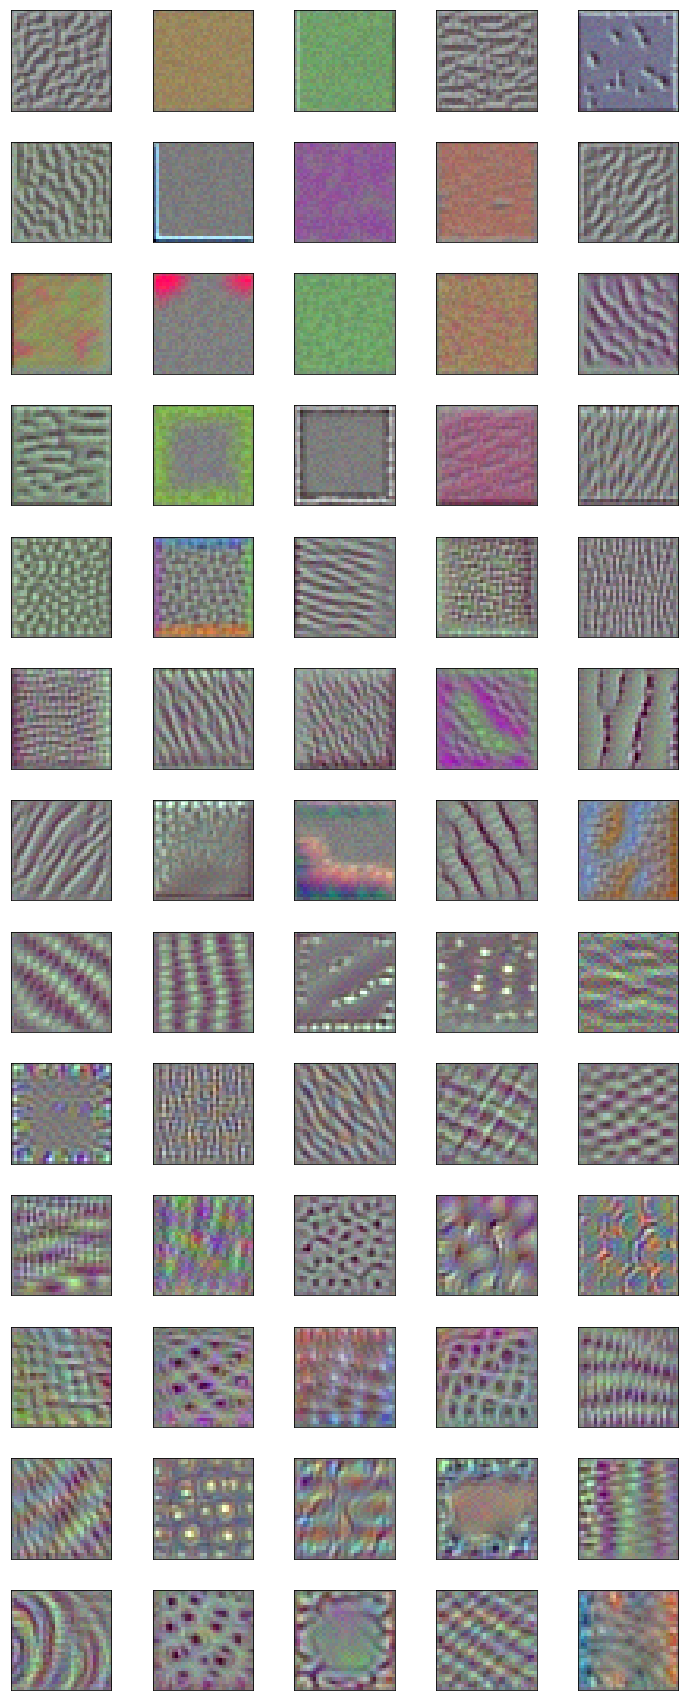

In [97]:
from matplotlib import pyplot as plt

from matplotlib.pyplot import subplots_adjust

def remove_axes(fig):
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    for ax in fig.axes:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


def plot_images(images, figsize, columns, rows):

    fig = plt.figure()
    columns = 5
    rows = 13 #13 different conv layers
    for x, i in zip(range(1, columns * rows + 1), images):
        fig.add_subplot(rows, columns, x)
        plt.imshow(i)
    remove_axes(fig)
    plt.show()

#rows = ['Row {}'.format(row) for row in [str(x+1) for x in range(13)]]   
#for ax, row in zip(axes[:,0], rows):
#    ax.set_ylabel(row, rotation=0, size='large')


In [75]:
images = [k[0] for k in kept_filters]
images = np.stack(images)
images = images.astype(np.float32)
images/=255

In [55]:
len([layer_name for layer_name in layer_dict if 'conv1' in layer_name])

5

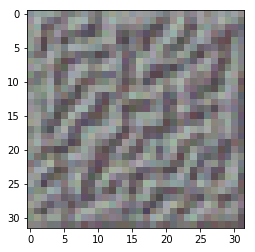

In [83]:
plt.imshow(images[0])

In [1]:
from visualisations import get_filters
from keras import applications

model = applications.VGG16(weights='imagenet', 
                           include_top=False)
filters = get_filters(model)

Using TensorFlow backend.


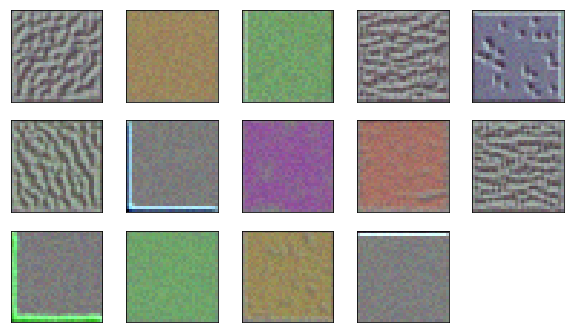

In [6]:
from visualisations import plot_images
plot_images(filters, size=(10, 26), columns=5, rows=13)

In [25]:
from matplotlib import pyplot as plt
import numpy as np
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 32
img_height = 32


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def prepare_images(kept_filters):
    images = [k[0] for k in kept_filters]
    images = np.stack(images)
    images = images.astype(np.float32)
    images /= 255
    return images

def get_filters(model):
    """
    This code comes almost entirely from keral tutorial page.
    :param model: pretrained model, that filters we'd like to visualise.
    :return:
    """
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    kept_filters = []
    for layer_name in layer_dict.keys():
        if 'conv' not in layer_name:
            continue
        layer_filters = []
        for filter_index in range(15):
            layer_output = layer_dict[layer_name].output
            if K.image_data_format() == 'channels_first':
                loss = K.mean(layer_output[:, filter_index, :, :])
            else:
                loss = K.mean(layer_output[:, :, :, filter_index])
            grads = K.gradients(loss, input_img)[0]
            grads = normalize(grads)
            iterate = K.function([input_img], [loss, grads])
            step = 1.
            if K.image_data_format() == 'channels_first':
                input_img_data = np.random.random((1, 3, img_width, img_height))
            else:
                input_img_data = np.random.random((1, img_width, img_height, 3))
            input_img_data = (input_img_data - 0.5) * 20 + 128

            for i in range(20):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step
                if loss_value <= 0.:
                    break
            if loss_value > 0:
                img = deprocess_image(input_img_data[0])
                kept_filters.append((img, loss_value))
        layer_filters.sort(key=lambda x: x[1], reverse=True)
        kept_filters += layer_filters[:8]
    return prepare_images(kept_filters)
    

In [2]:
from visualisations import get_filters
new_filters = get_filters(model)

Using TensorFlow backend.


NameError: name 'model' is not defined

In [29]:
new_filters = _26

In [36]:
from visualisations import plot_images
plot_images(new_filters, figsize=(10, 26), columns=5, rows=13)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

In [32]:
plt.figure(figsize=(10,15))

<Figure size 720x1080 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

In [2]:
def get_model_outputs(layer_name, images):
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[layer_name].output
    input_img = model.input
    get_features = K.function([layer_output], [input_img])
    features = [get_features([image]) for image in images]
        